<a href="https://colab.research.google.com/github/rkanejac/Data110/blob/main/RealProject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install folium

In [15]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium
from branca.colormap import linear
import plotly.express as px
import datetime

#import data
df = pd.read_csv('/content/USChronicDiseaseIndicators.csv')
geo_url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
health = pd.DataFrame(df)

#health.info()
rows = len(health.axes[0])
columns = len(health.axes[1])

print(rows)
print(columns)

<ipython-input-15-1179f7c9e69b>:12: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/USChronicDiseaseIndicators.csv')


969216
34


# Exploratory Analysis

In [16]:
#cleaning and filtering the data
dropped_columns =['Response', 'DataValueFootnoteSymbol', 'StratificationCategory2', 'Stratification2', 'StratificationCategory3', 'Stratification3', 'StratificationCategoryID1', 'StratificationID1', 'StratificationCategoryID2', 'StratificationID2','StratificationCategoryID3', 'StratificationID3', 'ResponseID']
health = health.drop(labels=dropped_columns, axis = 1)

# #removing all rows with nulls from the datavalue andr datavaluealt columns
health = health[health['DataValue'].notna()]
health = health[health['DataValueAlt'].notna()]
health.info()



<class 'pandas.core.frame.DataFrame'>
Index: 653168 entries, 0 to 969215
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   YearStart                653168 non-null  int64  
 1   YearEnd                  653168 non-null  int64  
 2   LocationAbbr             653168 non-null  object 
 3   LocationDesc             653168 non-null  object 
 4   DataSource               653168 non-null  object 
 5   Topic                    653168 non-null  object 
 6   Question                 653168 non-null  object 
 7   DataValueUnit            559002 non-null  object 
 8   DataValueType            653168 non-null  object 
 9   DataValue                653168 non-null  object 
 10  DataValueAlt             653168 non-null  float64
 11  DatavalueFootnote        12102 non-null   object 
 12  LowConfidenceLimit       544040 non-null  float64
 13  HighConfidenceLimit      544040 non-null  float64
 14  Stratific

In [17]:
health['Topic'].unique()

array(['Alcohol', 'Arthritis', 'Asthma', 'Cancer',
       'Cardiovascular Disease', 'Chronic Kidney Disease',
       'Chronic Obstructive Pulmonary Disease', 'Diabetes', 'Disability',
       'Immunization', 'Mental Health',
       'Nutrition, Physical Activity, and Weight Status', 'Older Adults',
       'Oral Health', 'Overarching Conditions'], dtype=object)

In [18]:
#which chronic dieases cause the highest mortality rate
health['Stuff'] = health['Question'].str.contains('mortality', case=False, regex=False) #find all of the questions that have the word mortality in it
mortality = health.drop(health[health['Stuff'] == False].index) #droping all rows that dont have mortality in it
#mortality = mortality[mortality['StratificationCategory1'] == 'Overall']
questions = mortality['Question'].unique()
mortality.head()



,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,...,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,GeoLocation,LocationID,TopicID,QuestionID,DataValueTypeID,Stuff
0,2015,2015,AR,Arkansas,NVSS,Alcohol,Chronic liver disease mortality,NaN,Number,266,...,NaN,NaN,Gender,Male,POINT (-92.27449074299966 34.74865012400045),5,ALC,ALC6_0,NMBR,True
1,2018,2018,AR,Arkansas,NVSS,Alcohol,Chronic liver disease mortality,NaN,Number,267,...,NaN,NaN,Gender,Male,POINT (-92.27449074299966 34.74865012400045),5,ALC,ALC6_0,NMBR,True
2,2015,2015,CA,California,NVSS,Alcohol,Chronic liver disease mortality,NaN,Number,3502,...,NaN,NaN,Gender,Male,POINT (-120.99999953799971 37.63864012300047),6,ALC,ALC6_0,NMBR,True
3,2015,2015,CO,Colorado,NVSS,Alcohol,Chronic liver disease mortality,NaN,Number,276,...,NaN,NaN,Gender,Female,POINT (-106.13361092099967 38.843840757000464),8,ALC,ALC6_0,NMBR,True
4,2013,2013,DC,District of Columbia,NVSS,Alcohol,Chronic liver disease mortality,NaN,Number,37,...,NaN,NaN,Gender,Male,POINT (-77.036871 38.907192),11,ALC,ALC6_0,NMBR,True


Text(0, 0.5, 'Chronic Diseases')

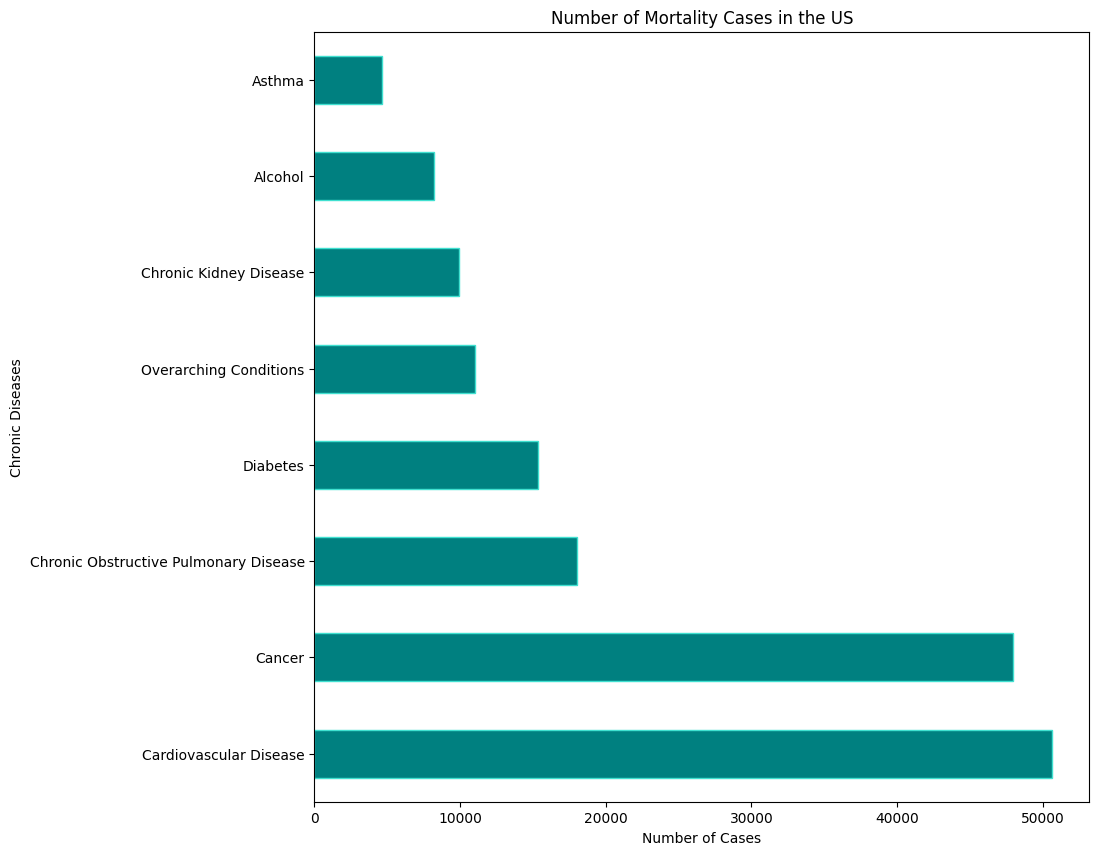

In [19]:
#what are the top three chronic dieases killers
plt.figure( figsize = (10,10))
mortality['Topic'].value_counts().plot(kind='barh', color='teal', edgecolor = 'turquoise')
plt.title('Number of Mortality Cases in the US')
plt.xlabel('Number of Cases')
plt.ylabel('Chronic Diseases')

In [20]:
#creating map of cvd deaths (which states have the highest numbers)
cvd = mortality[mortality['Topic'] == 'Cardiovascular Disease']
cvd['Question'].unique()

array(['Mortality from coronary heart disease',
       'Mortality from heart failure',
       'Mortality from diseases of the heart',
       'Mortality from cerebrovascular disease (stroke)',
       'Mortality from total cardiovascular diseases'], dtype=object)

In [21]:
cvd['Question'].value_counts()

Question
Mortality from total cardiovascular diseases       10923
Mortality from diseases of the heart               10617
Mortality from coronary heart disease              10014
Mortality from heart failure                        9849
Mortality from cerebrovascular disease (stroke)     9267
Name: count, dtype: int64

In [22]:
coronary_g = cvd[(cvd['Question'] == 'Mortality from coronary heart disease') & (cvd['StratificationCategory1'] == 'Gender') & (cvd['DataValueType'] == 'Number') ]
heartdieases_g = cvd[(cvd['Question'] == 'Mortality from diseases of the heart') & (cvd['StratificationCategory1'] == 'Gender') & (cvd['DataValueType'] == 'Number')]
totaldiease_g = cvd[(cvd['Question'] == 'Mortality from total cardiovascular diseases') & (cvd['StratificationCategory1'] == 'Gender') & (cvd['DataValueType'] == 'Number')]
failure_g = cvd[(cvd['Question'] == 'Mortality from heart failure') & (cvd['StratificationCategory1'] == 'Gender') & (cvd['DataValueType'] == 'Number')]
stroke_g = cvd[(cvd['Question'] == 'Mortality from cerebrovascular disease (stroke)') & (cvd['StratificationCategory1'] == 'Gender') & (cvd['DataValueType'] == 'Number')]
cvd['Question'].value_counts()

#coronarytrend
years = cvd['YearStart'].unique()
print(years)



[2011 2014 2015 2012 2016 2010 2013 2017 2019 2018]


[2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]
['Male' 'Female']


Text(0.5, 0, 'Years')

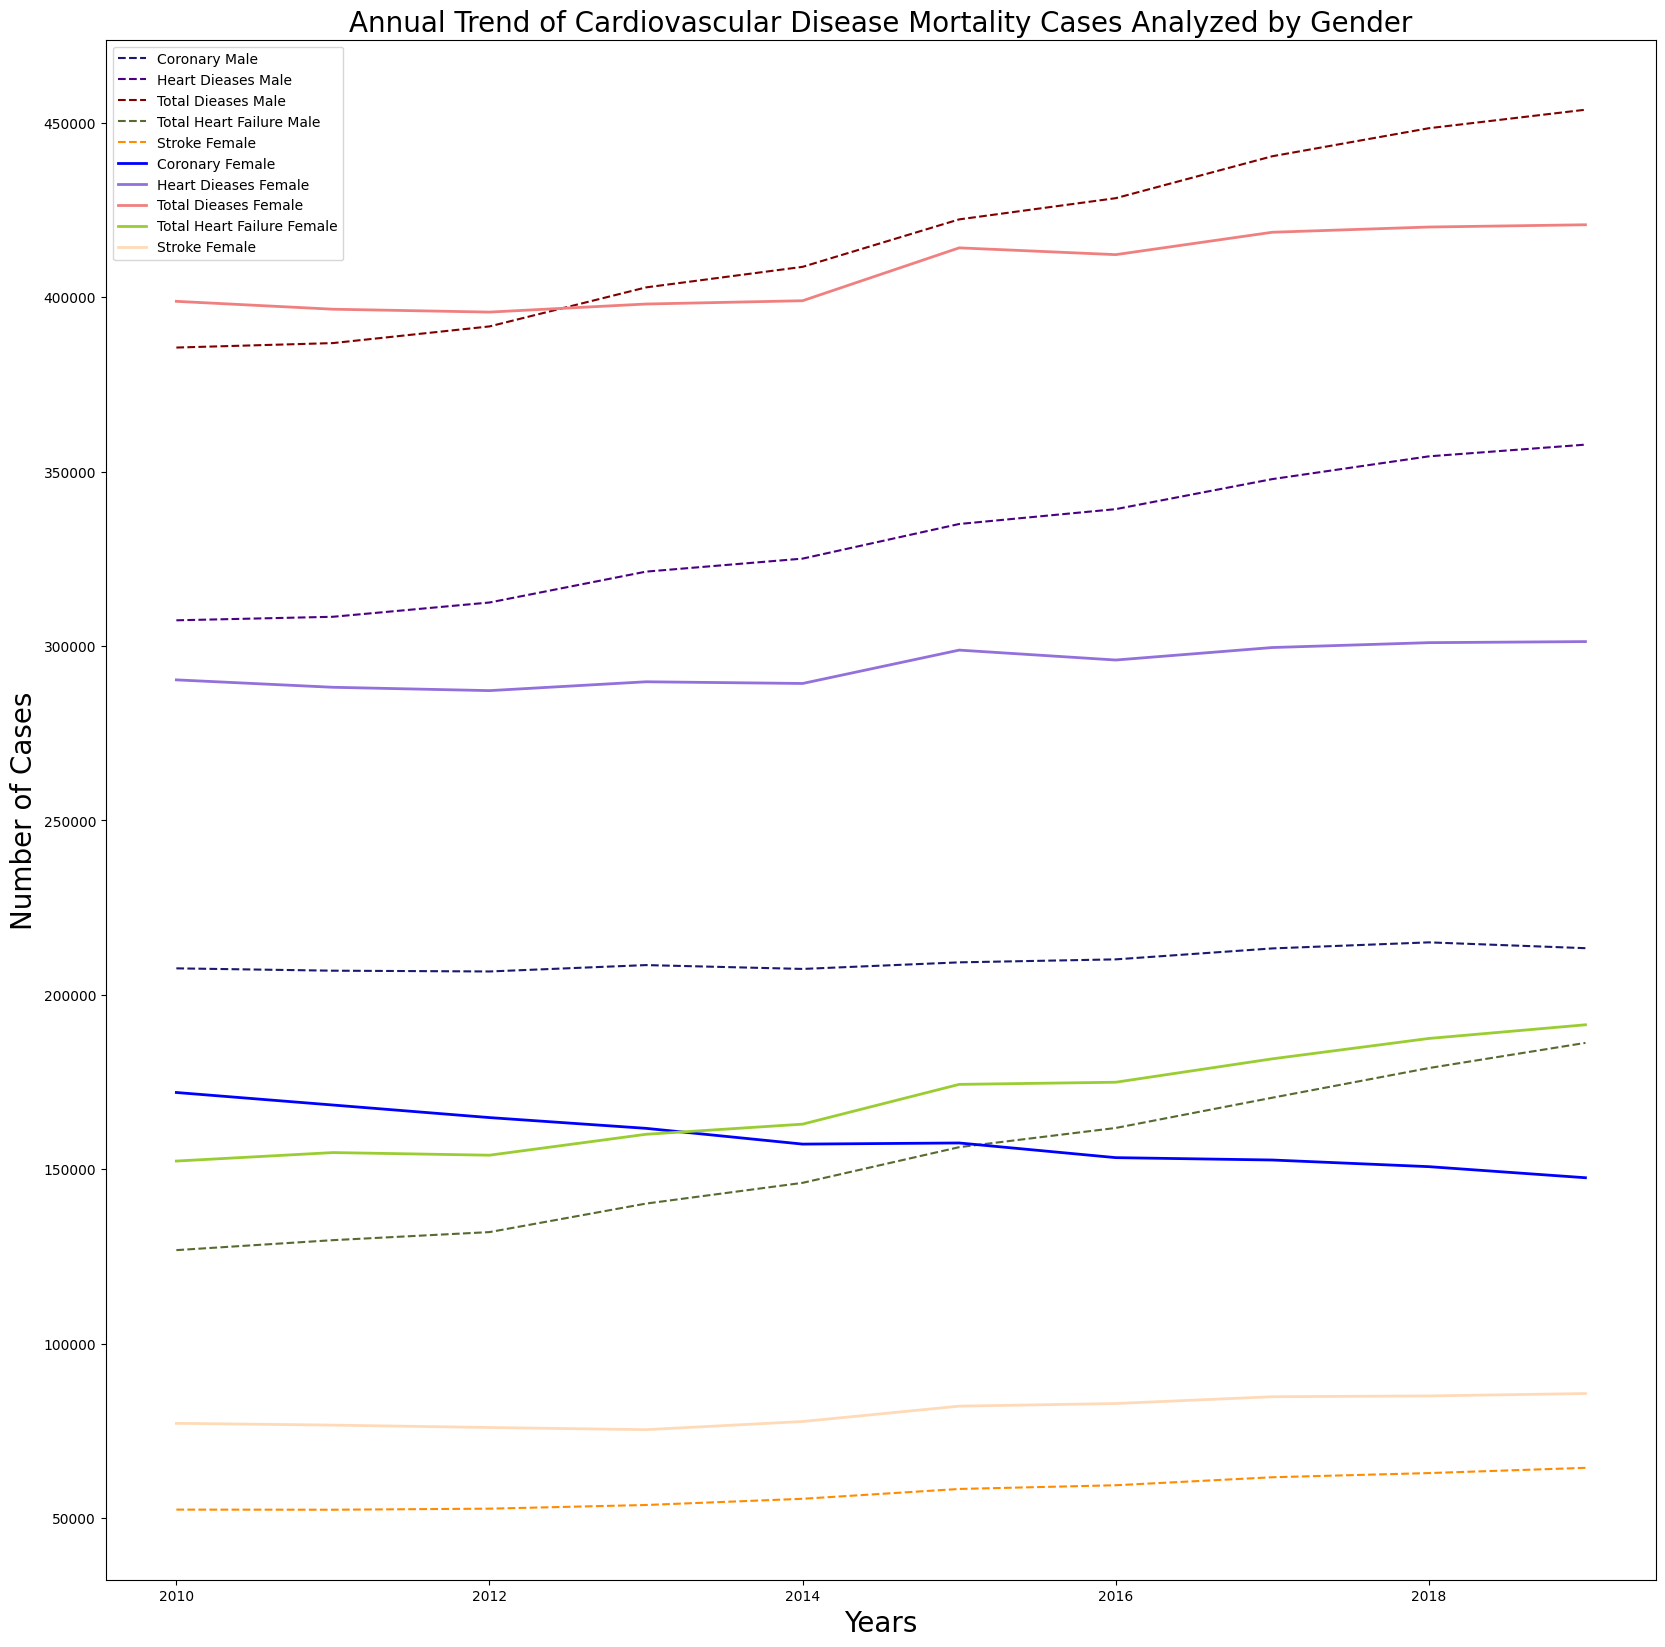

In [25]:
#genderanalysisbyyear (which gender has the highest chance of dying from a cvd )
years = pd.DataFrame(columns=['Years'])
yearss = cvd['YearStart'].sort_values()
yearss = yearss.unique()
print(yearss)

gender_coronary = coronary_g[(coronary_g['StratificationCategory1'] == 'Gender') & (coronary_g['DataValueType'] == 'Number')]
genders = gender_coronary['Stratification1'].unique()
print(genders)

deaths1 = pd.DataFrame(columns = ['Year', 'Gender', 'Count'])

grouped_coronary_data = coronary_g.groupby(['YearStart','DataValueType','StratificationCategory1','Stratification1'], dropna = True)['DataValueAlt'].sum().unstack()
grouped_heartdieases_data = heartdieases_g.groupby(['YearStart', 'DataValueType','StratificationCategory1','Stratification1'], dropna = True)['DataValueAlt'].sum().unstack()
grouped_totaldiease_data = totaldiease_g.groupby(['YearStart', 'DataValueType','StratificationCategory1','Stratification1'], dropna = True)['DataValueAlt'].sum().unstack()
grouped_failure_data = failure_g.groupby(['YearStart', 'DataValueType','StratificationCategory1','Stratification1'], dropna = True)['DataValueAlt'].sum().unstack()
grouped_stroke_data = stroke_g.groupby(['YearStart', 'DataValueType','StratificationCategory1','Stratification1'], dropna = True)['DataValueAlt'].sum().unstack()

grouped_coronary_data['Year'] = yearss
grouped_heartdieases_data['Year'] = yearss
grouped_totaldiease_data['Year'] = yearss
grouped_stroke_data['Year'] = yearss
grouped_failure_data['Year'] = yearss

plt.figure( figsize = (20,20))
for gender in genders:
  if gender == 'Female':
    plt.plot(grouped_coronary_data['Year'], grouped_coronary_data[gender], color = 'blue', linewidth = 2, label = 'Coronary Female')
    plt.plot(grouped_heartdieases_data['Year'], grouped_heartdieases_data[gender], color = 'mediumpurple', linewidth = 2, label = 'Heart Dieases Female')
    plt.plot(grouped_totaldiease_data['Year'], grouped_totaldiease_data[gender], color = 'lightcoral', linewidth = 2, label = 'Total Dieases Female')
    plt.plot(grouped_failure_data['Year'], grouped_failure_data[gender], color = 'yellowgreen', linewidth = 2, label = 'Total Heart Failure Female')
    plt.plot(grouped_stroke_data['Year'], grouped_stroke_data[gender], color = 'peachpuff', linewidth = 2, label = 'Stroke Female')
    plt.legend(loc = 'upper left')
  elif gender == 'Male':
    plt.plot(grouped_coronary_data['Year'], grouped_coronary_data[gender], color = 'midnightblue', linestyle = '--', label = 'Coronary Male')
    plt.plot(grouped_heartdieases_data['Year'], grouped_heartdieases_data[gender], color = 'indigo', linestyle = '--', label = 'Heart Dieases Male')
    plt.plot(grouped_totaldiease_data['Year'], grouped_totaldiease_data[gender], color = 'maroon', linestyle = '--', label = 'Total Dieases Male')
    plt.plot(grouped_failure_data['Year'], grouped_failure_data[gender], color = 'darkolivegreen', linestyle = '--', label = 'Total Heart Failure Male')
    plt.plot(grouped_stroke_data['Year'], grouped_stroke_data[gender], color = 'darkorange', linestyle = '--', label = 'Stroke Female')
    plt.legend(loc = 'upper left')

plt.title('Annual Trend of Cardiovascular Disease Mortality Cases Analyzed by Gender', fontsize=20)
plt.ylabel('Number of Cases', fontsize=20)
plt.xlabel('Years', fontsize=20)





# plt.plot(grouped_coronary_data['Year'], grouped_coronary_data['Male'], color = 'blue')




Text(0.5, 0, 'Years')

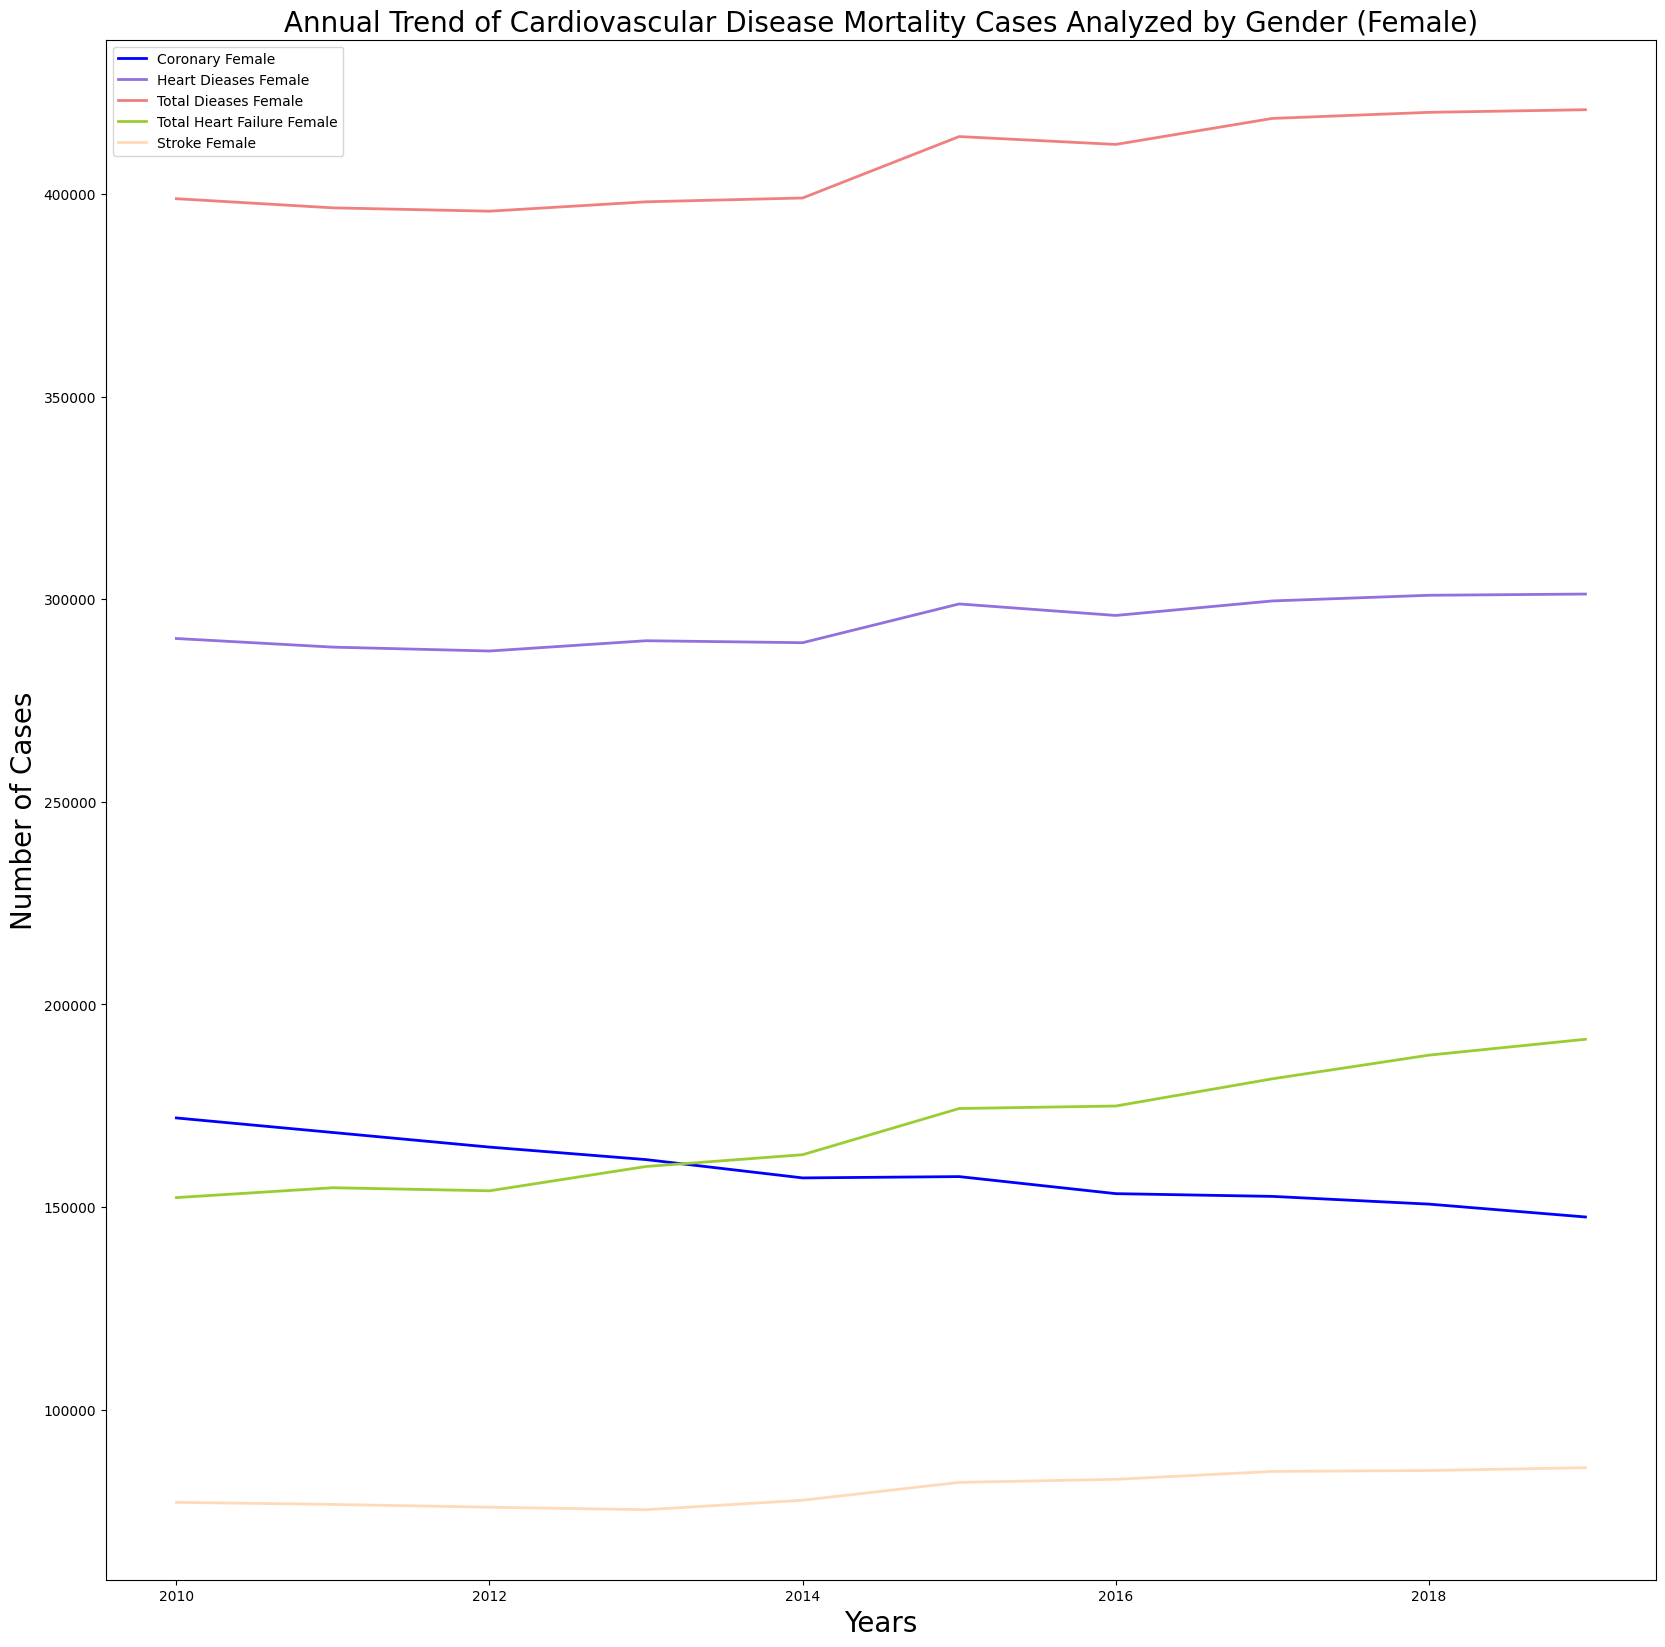

In [26]:
  plt.figure( figsize = (20,20))
  plt.plot(grouped_coronary_data['Year'], grouped_coronary_data['Female'], color = 'blue', linewidth = 2, label = 'Coronary Female')
  plt.plot(grouped_heartdieases_data['Year'], grouped_heartdieases_data['Female'], color = 'mediumpurple', linewidth = 2, label = 'Heart Dieases Female')
  plt.plot(grouped_totaldiease_data['Year'], grouped_totaldiease_data['Female'], color = 'lightcoral', linewidth = 2, label = 'Total Dieases Female')
  plt.plot(grouped_failure_data['Year'], grouped_failure_data['Female'], color = 'yellowgreen', linewidth = 2, label = 'Total Heart Failure Female')
  plt.plot(grouped_stroke_data['Year'], grouped_stroke_data['Female'], color = 'peachpuff', linewidth = 2, label = 'Stroke Female')
  plt.legend(loc = 'upper left')

plt.title('Annual Trend of Cardiovascular Disease Mortality Cases Analyzed by Gender (Female)', fontsize=20)
plt.ylabel('Number of Cases', fontsize=20)
plt.xlabel('Years', fontsize=20)

Text(0.5, 0, 'Years')

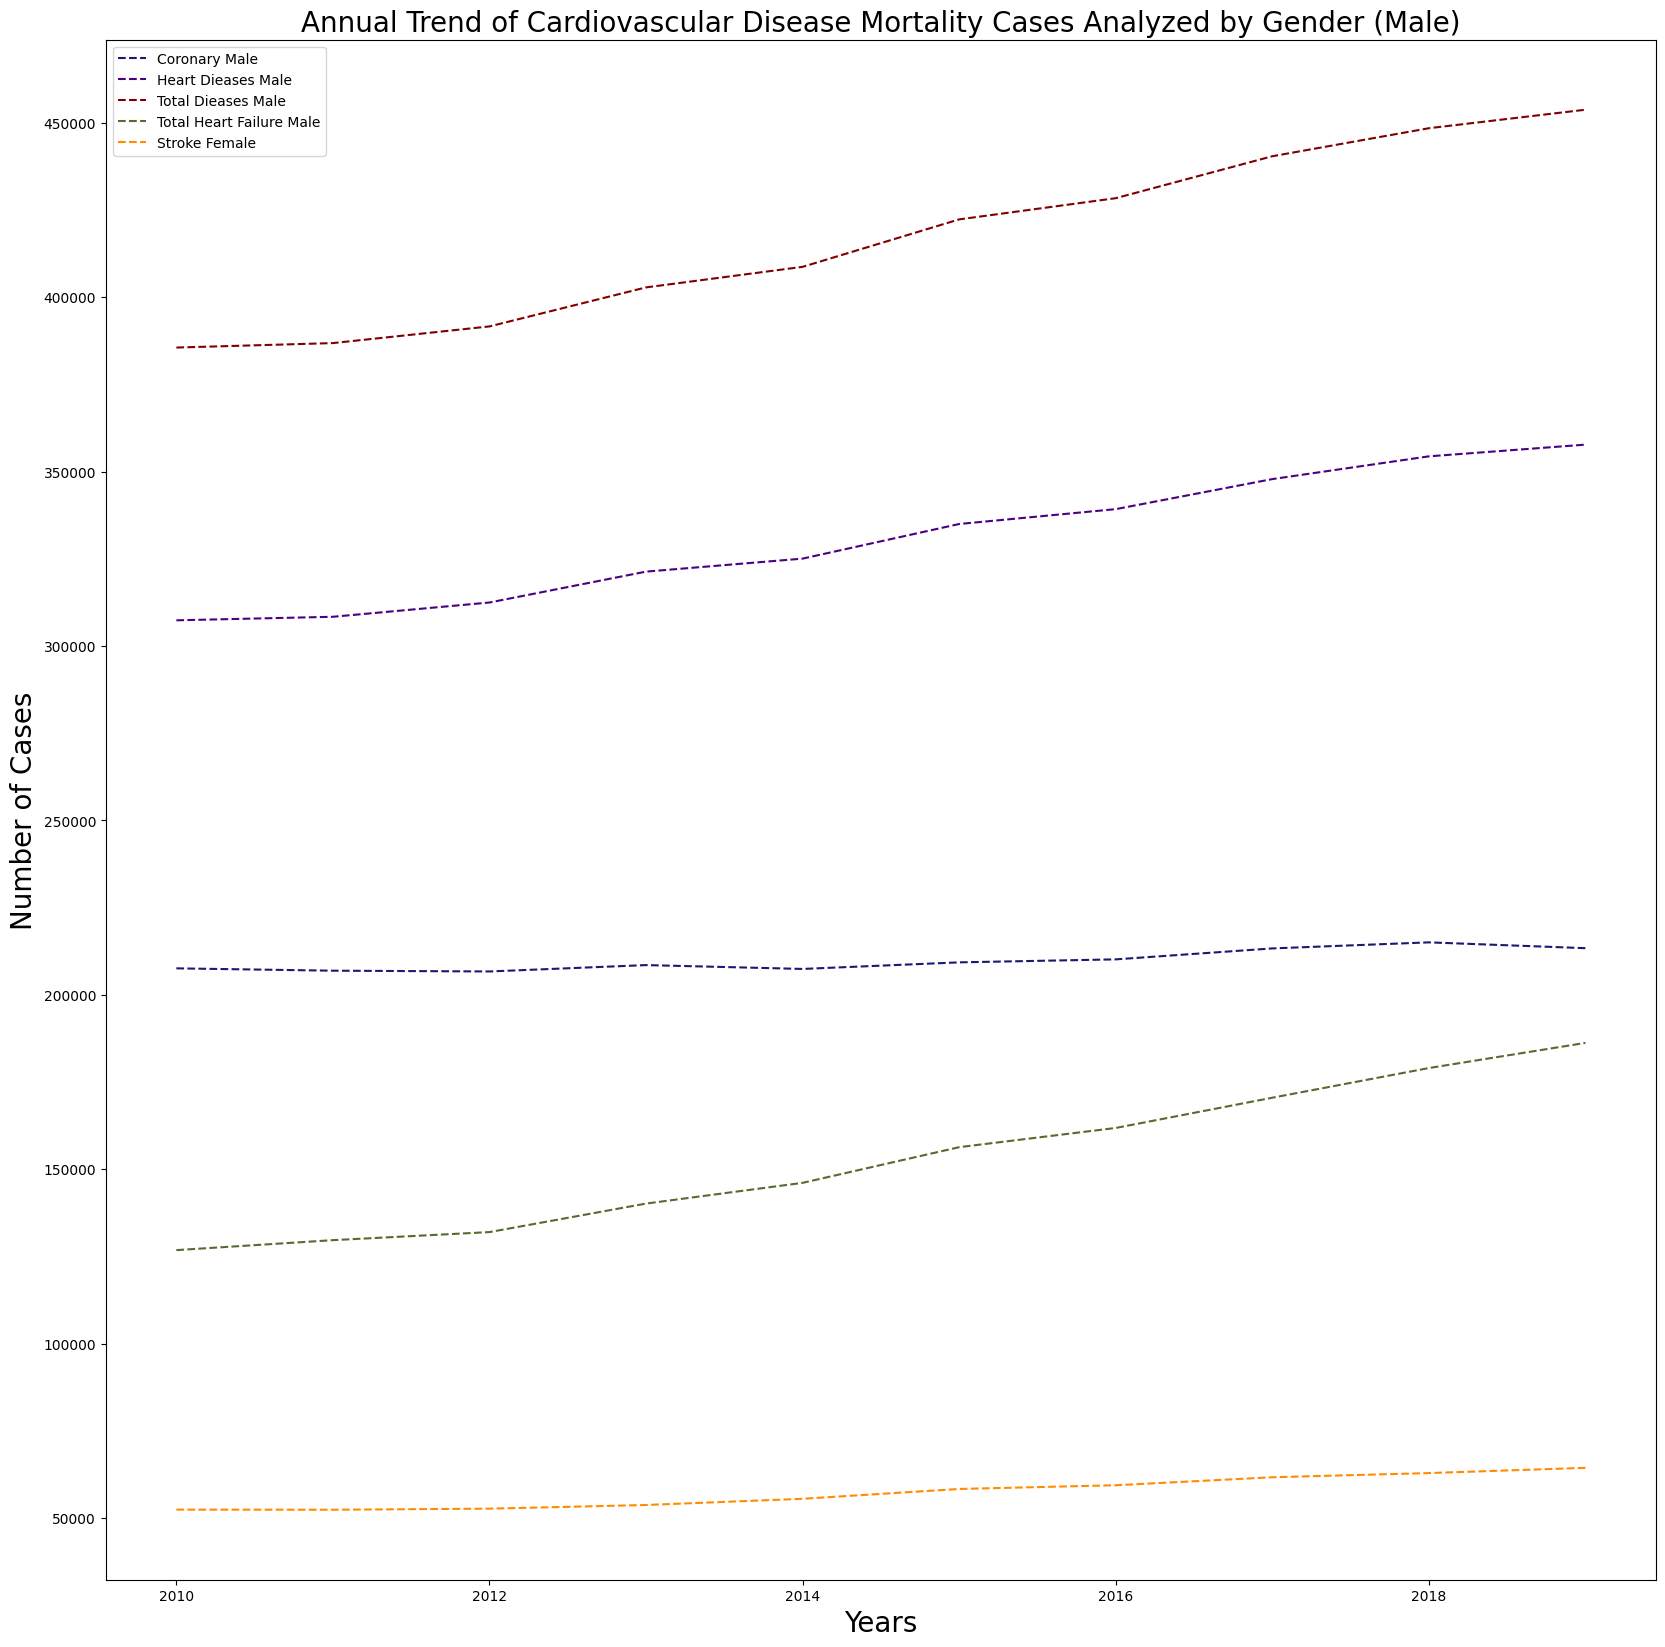

In [27]:
plt.figure( figsize = (20,20))
plt.plot(grouped_coronary_data['Year'], grouped_coronary_data['Male'], color = 'midnightblue', linestyle = '--', label = 'Coronary Male')
plt.plot(grouped_heartdieases_data['Year'], grouped_heartdieases_data['Male'], color = 'indigo', linestyle = '--', label = 'Heart Dieases Male')
plt.plot(grouped_totaldiease_data['Year'], grouped_totaldiease_data['Male'], color = 'maroon', linestyle = '--', label = 'Total Dieases Male')
plt.plot(grouped_failure_data['Year'], grouped_failure_data['Male'], color = 'darkolivegreen', linestyle = '--', label = 'Total Heart Failure Male')
plt.plot(grouped_stroke_data['Year'], grouped_stroke_data['Male'], color = 'darkorange', linestyle = '--', label = 'Stroke Female')
plt.legend(loc = 'upper left')


plt.title('Annual Trend of Cardiovascular Disease Mortality Cases Analyzed by Gender (Male)', fontsize=20)
plt.ylabel('Number of Cases', fontsize=20)
plt.xlabel('Years', fontsize=20)

In [28]:
#raceanalysis (which race has the highest chance of dying from cvd)
coronary_r = cvd[(cvd['Question'] == 'Mortality from coronary heart disease') & (cvd['StratificationCategory1'] == 'Race/Ethnicity') & (cvd['DataValueType'] == 'Number') ]
heartdieases_r = cvd[(cvd['Question'] == 'Mortality from diseases of the heart') & (cvd['StratificationCategory1'] == 'Race/Ethnicity') & (cvd['DataValueType'] == 'Number')]
totaldiease_r = cvd[(cvd['Question'] == 'Mortality from total cardiovascular diseases') & (cvd['StratificationCategory1'] == 'Race/Ethnicity') & (cvd['DataValueType'] == 'Number')]
failure_r = cvd[(cvd['Question'] == 'Mortality from heart failure') & (cvd['StratificationCategory1'] == 'Race/Ethnicity') & (cvd['DataValueType'] == 'Number')]
stroke_r = cvd[(cvd['Question'] == 'Mortality from cerebrovascular disease (stroke)') & (cvd['StratificationCategory1'] == 'Race/Ethnicity') & (cvd['DataValueType'] == 'Number')]
cvd['Question'].value_counts()

grouped_coronary_data_r = coronary_r.groupby(['YearStart', 'DataValueType','StratificationCategory1','Stratification1'], dropna = True)['DataValueAlt'].sum().unstack()
grouped_heartdieases_data_r = heartdieases_r.groupby(['YearStart', 'DataValueType','StratificationCategory1','Stratification1'], dropna = True)['DataValueAlt'].sum().unstack()
grouped_totaldiease_data_r = totaldiease_r.groupby(['YearStart', 'DataValueType','StratificationCategory1','Stratification1'], dropna = True)['DataValueAlt'].sum().unstack()
grouped_failure_data_r = failure_r.groupby(['YearStart', 'DataValueType','StratificationCategory1','Stratification1'], dropna = True)['DataValueAlt'].sum().unstack()
grouped_stroke_data_r = stroke_r.groupby(['YearStart', 'DataValueType','StratificationCategory1','Stratification1'], dropna = True)['DataValueAlt'].sum().unstack()



grouped_coronary_data_r['Year'] = yearss
grouped_heartdieases_data_r['Year'] = yearss
grouped_totaldiease_data_r['Year'] = yearss
grouped_stroke_data_r['Year'] = yearss
grouped_failure_data_r['Year'] = yearss

grouped_coronary_data_r['Year'] = grouped_coronary_data_r['Year'].astype(int)
grouped_coronary_data_r.head(10)

,,Stratification1,American Indian or Alaska Native,Asian or Pacific Islander,"Black, non-Hispanic",Hispanic,"White, non-Hispanic",Year
YearStart,DataValueType,StratificationCategory1,,,,,,
2010,Number,Race/Ethnicity,1511.0,7521.0,38991.0,20337.0,309492.0,2010
2011,Number,Race/Ethnicity,1546.0,7483.0,38877.0,20222.0,305486.0,2011
2012,Number,Race/Ethnicity,1631.0,7794.0,38948.0,20628.0,300439.0,2012
2013,Number,Race/Ethnicity,1724.0,8295.0,39126.0,21705.0,297501.0,2013
2014,Number,Race/Ethnicity,1751.0,8190.0,38793.0,21778.0,291879.0,2014
2015,Number,Race/Ethnicity,1810.0,8754.0,38981.0,22950.0,291850.0,2015
2016,Number,Race/Ethnicity,1829.0,8950.0,40093.0,23431.0,287032.0,2016
2017,Number,Race/Ethnicity,1766.0,9654.0,40147.0,24137.0,288019.0,2017
2018,Number,Race/Ethnicity,1850.0,9973.0,40757.0,24714.0,286405.0,2018


['Hispanic' 'Black, non-Hispanic' 'Asian or Pacific Islander'
 'American Indian or Alaska Native' 'White, non-Hispanic']
[2011 2014 2015 2012 2016 2010 2013 2017 2019 2018]


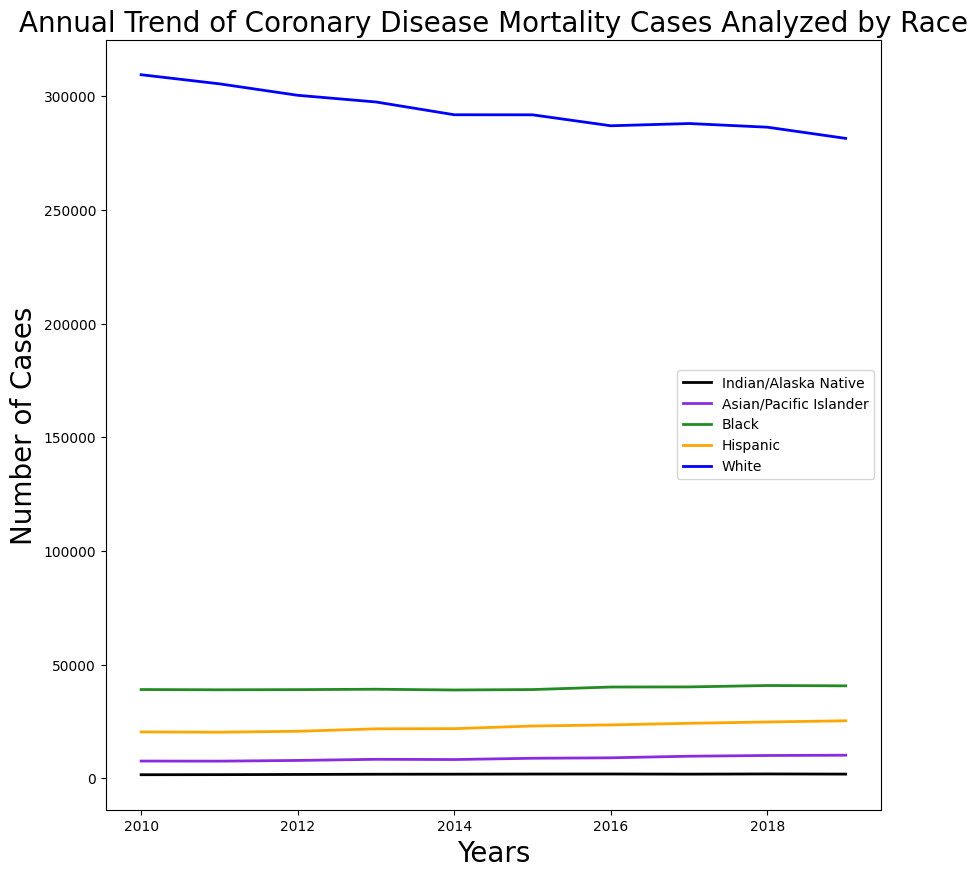

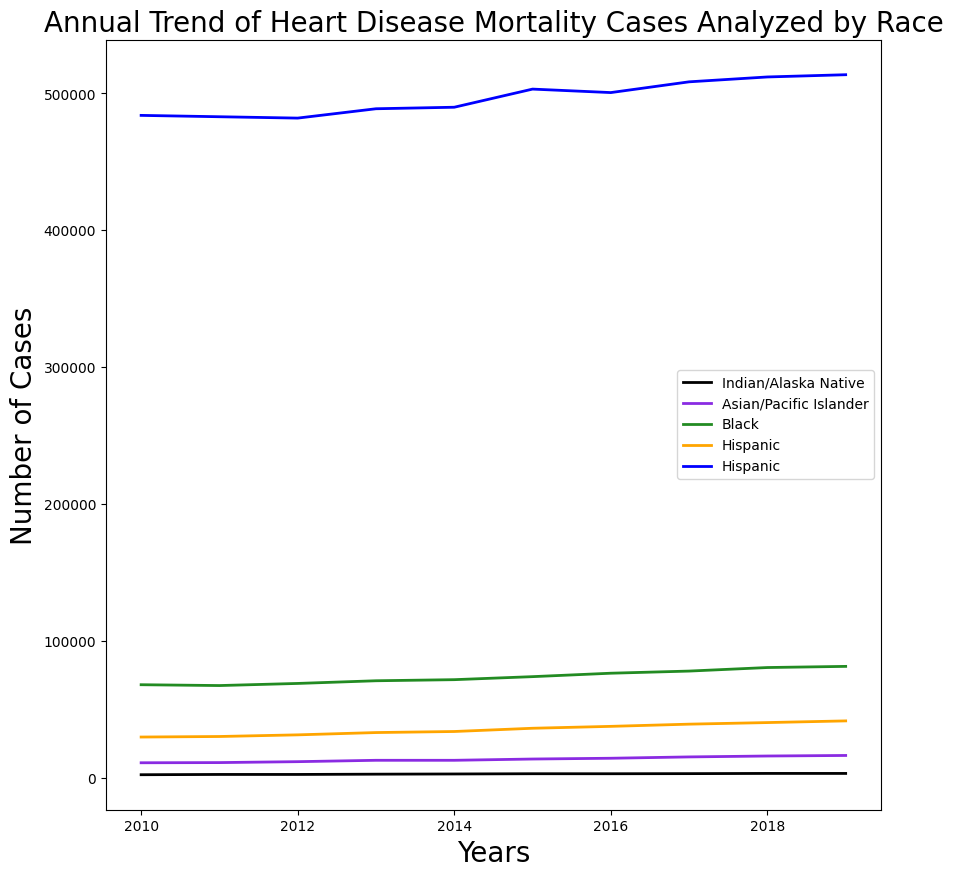

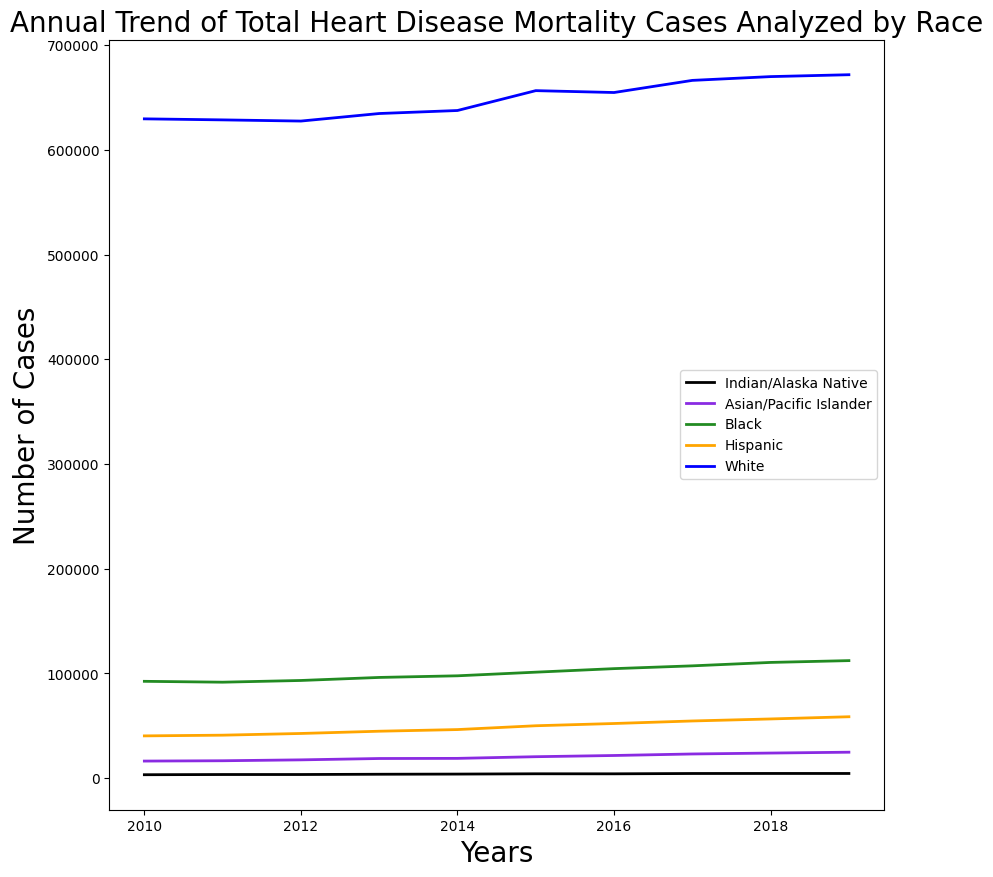

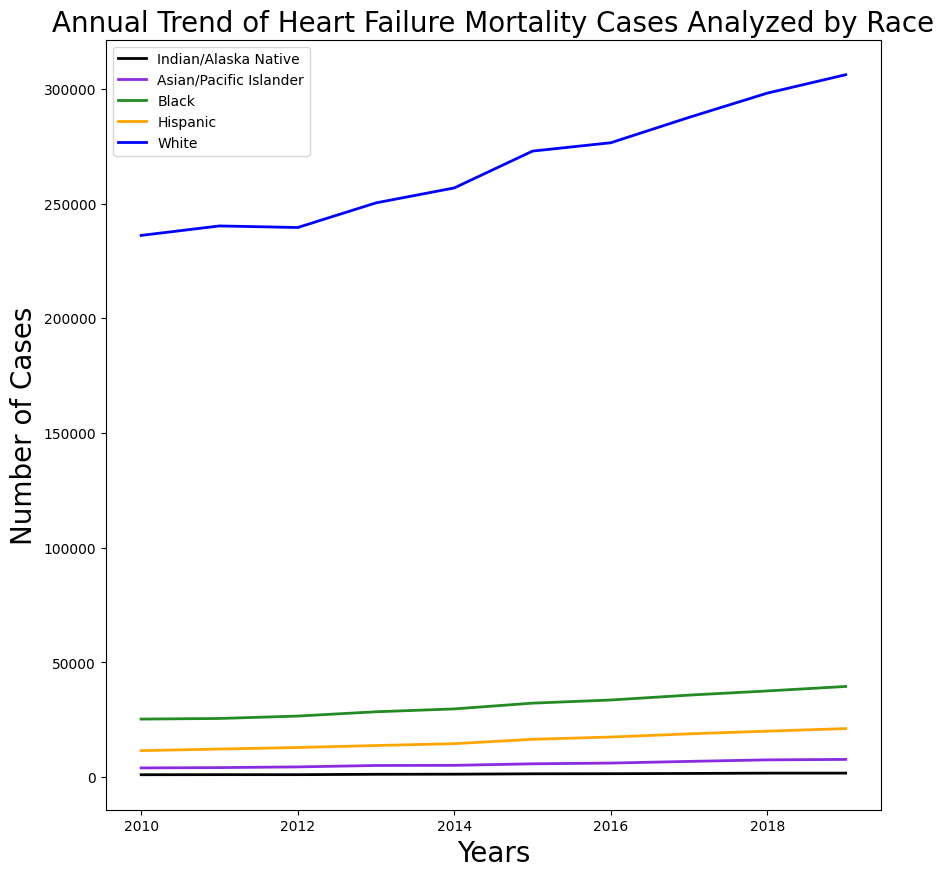

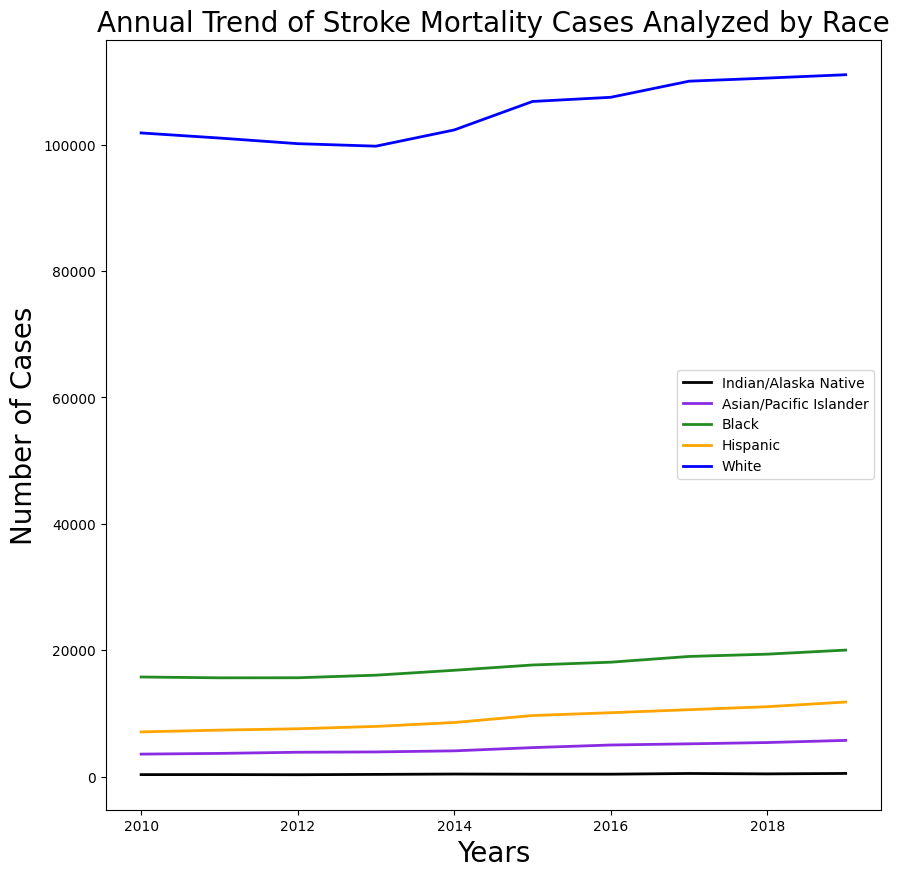

In [32]:
races = cvd[cvd['StratificationCategory1'] == 'Race/Ethnicity']['Stratification1'].unique()
print(races)

years = cvd['YearStart'].unique()
print(years)

# plt.figure( figsize = (10,10))
# plt.bar(grouped_coronary_data_r['Year'], grouped_coronary_data_r['American Indian or Alaska Native'], width = 0.25, color = 'red')
# plt.bar(grouped_coronary_data_r['Year'], grouped_coronary_data_r['Asian or Pacific Islander'], bottom = grouped_coronary_data_r['American Indian or Alaska Native'],  width=0.25, color = 'midnightblue')
# plt.bar(grouped_coronary_data_r['Year'], grouped_coronary_data_r['Black, non-Hispanic'],bottom = grouped_coronary_data_r['American Indian or Alaska Native']+grouped_coronary_data_r['Asian or Pacific Islander'],width=0.25, color = 'blue')
# plt.bar(grouped_coronary_data_r['Year'], grouped_coronary_data_r['Hispanic'], bottom = grouped_coronary_data_r['American Indian or Alaska Native']+grouped_coronary_data_r['Asian or Pacific Islander']+grouped_coronary_data_r['Black, non-Hispanic'], width=0.25, color = 'dodgerblue')
# plt.bar(grouped_coronary_data_r['Year'], grouped_coronary_data_r['White, non-Hispanic'], bottom = grouped_coronary_data_r['American Indian or Alaska Native']+grouped_coronary_data_r['Asian or Pacific Islander']+grouped_coronary_data_r['Black, non-Hispanic']+grouped_coronary_data_r['Hispanic'], width=0.25, color = 'deepskyblue')
# plt.bar

plt.figure( figsize = (10,10))
plt.plot(grouped_coronary_data_r['Year'], grouped_coronary_data_r['American Indian or Alaska Native'],color = 'black', linewidth = 2, label='Indian/Alaska Native')
plt.plot(grouped_coronary_data_r['Year'], grouped_coronary_data_r['Asian or Pacific Islander'], color = 'blueviolet', linewidth = 2, label= 'Asian/Pacific Islander')
plt.plot(grouped_coronary_data_r['Year'], grouped_coronary_data_r['Black, non-Hispanic'], color = 'forestgreen', linewidth = 2, label= 'Black')
plt.plot(grouped_coronary_data_r['Year'], grouped_coronary_data_r['Hispanic'],color = 'orange', linewidth = 2, label='Hispanic')
plt.plot(grouped_coronary_data_r['Year'], grouped_coronary_data_r['White, non-Hispanic'],color = 'blue', linewidth = 2, label='White')
plt.title('Annual Trend of Coronary Disease Mortality Cases Analyzed by Race', fontsize=20)
plt.ylabel('Number of Cases', fontsize=20)
plt.xlabel('Years', fontsize=20)
plt.legend()


plt.figure( figsize = (10,10))
plt.plot(grouped_heartdieases_data_r['Year'], grouped_heartdieases_data_r['American Indian or Alaska Native'],color = 'black', linewidth = 2, label='Indian/Alaska Native')
plt.plot(grouped_heartdieases_data_r['Year'], grouped_heartdieases_data_r['Asian or Pacific Islander'], color = 'blueviolet', linewidth = 2,  label= 'Asian/Pacific Islander')
plt.plot(grouped_heartdieases_data_r['Year'], grouped_heartdieases_data_r['Black, non-Hispanic'],color = 'forestgreen', linewidth = 2,  label= 'Black')
plt.plot(grouped_heartdieases_data_r['Year'], grouped_heartdieases_data_r['Hispanic'],color = 'orange',linewidth = 2, label='Hispanic')
plt.plot(grouped_heartdieases_data_r['Year'], grouped_heartdieases_data_r['White, non-Hispanic'],color = 'blue',linewidth = 2, label='Hispanic')
plt.title('Annual Trend of Heart Disease Mortality Cases Analyzed by Race', fontsize=20)
plt.ylabel('Number of Cases', fontsize=20)
plt.xlabel('Years', fontsize=20)
plt.legend()


plt.figure( figsize = (10,10))
plt.plot(grouped_totaldiease_data_r['Year'], grouped_totaldiease_data_r['American Indian or Alaska Native'],color = 'black', linewidth = 2,label='Indian/Alaska Native')
plt.plot(grouped_totaldiease_data_r['Year'], grouped_totaldiease_data_r['Asian or Pacific Islander'], color = 'blueviolet', linewidth = 2, label= 'Asian/Pacific Islander')
plt.plot(grouped_totaldiease_data_r['Year'], grouped_totaldiease_data_r['Black, non-Hispanic'],color = 'forestgreen', linewidth = 2, label= 'Black')
plt.plot(grouped_totaldiease_data_r['Year'], grouped_totaldiease_data_r['Hispanic'],color = 'orange', linewidth = 2, label='Hispanic')
plt.plot(grouped_totaldiease_data_r['Year'], grouped_totaldiease_data_r['White, non-Hispanic'],color = 'blue', linewidth = 2, label='White')
plt.title('Annual Trend of Total Heart Disease Mortality Cases Analyzed by Race', fontsize=20)
plt.ylabel('Number of Cases', fontsize=20)
plt.xlabel('Years', fontsize=20)
plt.legend()

plt.figure( figsize = (10,10))
plt.plot(grouped_failure_data_r['Year'], grouped_failure_data_r['American Indian or Alaska Native'],color = 'black', linewidth = 2, label='Indian/Alaska Native')
plt.plot(grouped_failure_data_r['Year'], grouped_failure_data_r['Asian or Pacific Islander'], color = 'blueviolet',linewidth = 2, label= 'Asian/Pacific Islander')
plt.plot(grouped_failure_data_r['Year'], grouped_failure_data_r['Black, non-Hispanic'],color = 'forestgreen',linewidth = 2, label= 'Black')
plt.plot(grouped_failure_data_r['Year'], grouped_failure_data_r['Hispanic'],color = 'orange',linewidth = 2, label='Hispanic')
plt.plot(grouped_failure_data_r['Year'], grouped_failure_data_r['White, non-Hispanic'],color = 'blue',linewidth = 2, label='White')
plt.title('Annual Trend of Heart Failure Mortality Cases Analyzed by Race', fontsize=20)
plt.ylabel('Number of Cases', fontsize=20)
plt.xlabel('Years', fontsize=20)
plt.legend()

plt.figure( figsize = (10,10))
plt.plot(grouped_stroke_data_r['Year'], grouped_stroke_data_r['American Indian or Alaska Native'],color = 'black',linewidth = 2, label='Indian/Alaska Native')
plt.plot(grouped_stroke_data_r['Year'], grouped_stroke_data_r['Asian or Pacific Islander'], color = 'blueviolet',linewidth = 2, label= 'Asian/Pacific Islander')
plt.plot(grouped_stroke_data_r['Year'], grouped_stroke_data_r['Black, non-Hispanic'],color = 'forestgreen',linewidth = 2, label= 'Black')
plt.plot(grouped_stroke_data_r['Year'], grouped_stroke_data_r['Hispanic'],color = 'orange',linewidth = 2, label='Hispanic')
plt.plot(grouped_stroke_data_r['Year'], grouped_stroke_data_r['White, non-Hispanic'],color = 'blue',linewidth = 2, label='White')
plt.title('Annual Trend of Stroke Mortality Cases Analyzed by Race', fontsize=20)
plt.ylabel('Number of Cases', fontsize=20)
plt.xlabel('Years', fontsize=20)
plt.legend()


# plt.bar(grouped_coronary_data_r['Year'], grouped_coronary_data_r['Asian or Pacific Islander'], bottom = grouped_coronary_data_r['American Indian or Alaska Native'],  width=0.25, color = 'midnightblue')
# plt.bar(grouped_coronary_data_r['Year'], grouped_coronary_data_r['Black, non-Hispanic'],bottom = grouped_coronary_data_r['American Indian or Alaska Native']+grouped_coronary_data_r['Asian or Pacific Islander'],width=0.25, color = 'blue')
# plt.bar(grouped_coronary_data_r['Year'], grouped_coronary_data_r['Hispanic'], bottom = grouped_coronary_data_r['American Indian or Alaska Native']+grouped_coronary_data_r['Asian or Pacific Islander']+grouped_coronary_data_r['Black, non-Hispanic'], width=0.25, color = 'dodgerblue')
# plt.bar(grouped_coronary_data_r['Year'], grouped_coronary_data_r['White, non-Hispanic'], bottom = grouped_coronary_data_r['American Indian or Alaska Native']+grouped_coronary_data_r['Asian or Pacific Islander']+grouped_coronary_data_r['Black, non-Hispanic']+grouped_coronary_data_r['Hispanic'], width=0.25, color = 'deepskyblue')
# plt.bar

#plt.plot(grouped_coronary_data['Year'], grouped_coronary_data['Female'], color = 'blue', linewidth = 2, label = 'Coronary Female')


In [ ]:
grouped_coronary_data_r['American Indian or Alaska Native'].sum()
# grouped_heartdieases_data_r
# grouped_totaldiease_data_r
# grouped_failure_data_r
# grouped_stroke_data_r

In [85]:
cvd2010s = cvd[(cvd['Stratification1'] == 'Overall') & (cvd['DataValueType']=='Number') & (cvd['YearStart'] == 2010)]
# cvd2010s.info()
# cvd2010s.head()
cvd_grouped = cvd2010s.groupby(['LocationDesc','YearStart','DataValueType','StratificationCategory1'], dropna = True)['DataValueAlt'].sum().unstack()
cvd_grouped.head(10)

# states = cvd2010s['LocationDesc'].unique()
# print(states)
# cvd_grouped.info()
# cvd_grouped.head(50)



,,StratificationCategory1,Overall
LocationDesc,YearStart,DataValueType,
Alabama,2010,Number,41832.0
Alaska,2010,Number,2498.0
Arizona,2010,Number,36679.0
Arkansas,2010,Number,27125.0
California,2010,Number,219992.0
Colorado,2010,Number,22975.0
Connecticut,2010,Number,25141.0
Delaware,2010,Number,6386.0
District of Columbia,2010,Number,4328.0


In [129]:
#2010
states = cvd['LocationDesc'].unique()

state_count = {}
for state in states:
  count = cvd[(cvd['LocationDesc'] == state) & (cvd['Stratification1'] == 'Overall') & (cvd['DataValueType']=='Number') & (cvd['YearStart'] == 2010)]['DataValueAlt'].sum()
  state_count[state] = count

print(state_count)
cvd2010 = pd.DataFrame(state_count.items(), columns=['state', 'count'])
cvd2010 = cvd2010.drop(cvd2010[cvd2010['state'] == 'United States'].index)

# cvd2010['Stuff'] = cvd2010['state'].str.contains('United', case=False, regex=False) #find all of the questions that have the word mortality in it


# health['Stuff'] = health['Question'].str.contains('mortality', case=False, regex=False) #find all of the questions that have the word mortality in it
# mortality = health.drop(health[health['Stuff'] == False].index



#2014
state_count = {}
for state in states:
  count = cvd[(cvd['LocationDesc'] == state) & (cvd['Stratification1'] == 'Overall') & (cvd['DataValueType']=='Number') & (cvd['YearStart'] == 2014)]['DataValueAlt'].sum()
  state_count[state] = count

print(state_count)
cvd2014 = pd.DataFrame(state_count.items(), columns=['state', 'count'])
cvd2014 = cvd2014.drop(cvd2014[cvd2014['state'] == 'United States'].index)

# cvd2014


#2018
state_count = {}
for state in states:
  count = cvd[(cvd['LocationDesc'] == state) & (cvd['Stratification1'] == 'Overall') & (cvd['DataValueType']=='Number') & (cvd['YearStart'] == 2018)]['DataValueAlt'].sum()
  state_count[state] = count

print(state_count)
cvd2018 = pd.DataFrame(state_count.items(), columns=['state', 'count'])
cvd2018 = cvd2018.drop(cvd2018[cvd2018['state'] == 'United States'].index)

cvd2018



{'Kansas': 20729.0, 'Maryland': 37967.0, 'New Mexico': 12165.0, 'New York': 155323.0, 'West Virginia': 18359.0, 'Wyoming': 3471.0, 'United States': 2170276.0, 'Alaska': 2498.0, 'Arkansas': 27125.0, 'Colorado': 22975.0, 'Florida': 147285.0, 'Alabama': 41832.0, 'Arizona': 36679.0, 'California': 219992.0, 'Connecticut': 25141.0, 'District of Columbia': 4328.0, 'Delaware': 6386.0, 'Georgia': 55882.0, 'Hawaii': 7982.0, 'Maine': 9735.0, 'Minnesota': 28685.0, 'Illinois': 89345.0, 'Iowa': 25871.0, 'Idaho': 9469.0, 'Indiana': 49144.0, 'Kentucky': 34696.0, 'Massachusetts': 43739.0, 'Louisiana': 35182.0, 'Michigan': 84085.0, 'Missouri': 50126.0, 'Montana': 6978.0, 'Mississippi': 27032.0, 'North Carolina': 63529.0, 'Nevada': 15213.0, 'Nebraska': 12875.0, 'North Dakota': 5607.0, 'New Hampshire': 8502.0, 'New Jersey': 65753.0, 'Ohio': 96064.0, 'Oklahoma': 34833.0, 'Oregon': 24806.0, 'Rhode Island': 8690.0, 'Pennsylvania': 112929.0, 'South Dakota': 6410.0, 'South Carolina': 33964.0, 'Texas': 141818.0

,state,count
0,Kansas,22223.0
1,Maryland,42046.0
2,New Mexico,14520.0
3,New York,153714.0
4,West Virginia,18664.0
5,Wyoming,3932.0
7,Alaska,3006.0
8,Arkansas,29472.0
9,Colorado,28691.0
10,Florida,176726.0


In [126]:
cvd2010


,state,count
0,Kansas,20729.0
1,Maryland,37967.0
2,New Mexico,12165.0
3,New York,155323.0
4,West Virginia,18359.0
5,Wyoming,3471.0
7,Alaska,2498.0
8,Arkansas,27125.0
9,Colorado,22975.0
10,Florida,147285.0


In [139]:
map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Create a choropleth map
folium.Choropleth(
    geo_data=geo_url,
    name='choropleth',
    data=cvd2010,
    columns=['state', 'count'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',  # Yellow-Orange-Red palette
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Environmental Quality Index',
    bins = [ 0, 1000, 2000, 3000, 4000, 5000, 10000, 15000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 200000, 250000]

).add_to(map)

folium.LayerControl().add_to(map)
map

In [138]:
map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Create a choropleth map
folium.Choropleth(
    geo_data=geo_url,
    name='choropleth',
    data=cvd2014,
    columns=['state', 'count'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',  # Yellow-Orange-Red palette
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Environmental Quality Index',
    bins = [ 0, 1000, 2000, 3000, 4000, 5000, 10000, 15000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 200000, 250000]
).add_to(map)

folium.LayerControl().add_to(map)
map

In [137]:
map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Create a choropleth map
folium.Choropleth(
    geo_data=geo_url,
    name='choropleth',
    data=cvd2018,
    columns=['state', 'count'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',  # Yellow-Orange-Red palette
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Environmental Quality Index',
    bins = [ 0, 1000, 2000, 3000, 4000, 5000, 10000, 15000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 200000, 250000]
).add_to(map)

folium.LayerControl().add_to(map)
map